In [1]:
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate, integrate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, turn_physical_off, MiyamotoNagaiPotential, plotDensities,evaluateDensities,plotPotentials
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util
import gd1_util
from gd1_util import R0, V0
import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from galpy.potential import DehnenSmoothWrapperPotential as DehnenWrap

ro=8.
vo=220.

#from matplotlib.ticker import FuncFormatter, NullFormatter

def galcencyl_to_lbd(R,phi,Z,degree=True):
    xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
    lbd=bovy_coords.XYZ_to_lbd(xyz[0],xyz[1],xyz[2],degree=degree)
    return lbd[0], lbd[1], lbd[2]

/home/nil/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

Populating the interactive namespace from numpy and matplotlib


In [2]:
#setup the bar

#Compute normalization rho_0

#constants
x0=1.49 # kpc
y0=0.58
z0=0.4
q= 0.6

Mbar=10**10 #Msun, half of what Wang is using, same as Pearson


def rho1(R,z):
    return (2.*np.pi*x0*y0)*R*np.exp(-0.5*(np.sqrt(R**4 + (z/z0)**4)))

rho1norm= integrate.nquad(rho1,[[0,np.inf],[-np.inf,np.inf]])[0]

def rho2(R):
    return (z0**1.85 *4.*np.pi/q**2)*R**(0.15)*np.exp(-R/z0)

rho2norm= integrate.quad(rho2,0,np.inf)[0]
rho0=Mbar/(rho1norm + rho2norm)

def r1c(R,z,p):
    return ((R**4.)*(np.cos(p)**2./x0**2 + np.sin(p)**2/y0**2)**2 + (z/z0)**4.)**(0.25)

def r2c(R,z):
    return np.sqrt((q*R)**2. + z**2.)/z0


def rho_bar_cyl(R,z,p):
    return rho0*(np.exp((-r1c(R,z,p)**2.)/2.) + r2c(R,z)**(-1.85)*np.exp(-r2c(R,z)))


def initial_angle(pat_speed,t_age_Gyr=5.,fin_phi_deg=27.):
    
    kpc_to_km= 1000.*bovy_conversion._PCIN10p18CM*(10**18.)/(10**5.)
    Gyr_to_s = 1000.*bovy_conversion._MyrIn1013Sec*10**13.
    o_p = (2.*np.pi)*(pat_speed/kpc_to_km)  #rad/s

    fin_phi= np.radians(fin_phi_deg)
    init_phi= fin_phi - o_p*(t_age_Gyr*Gyr_to_s)
    return init_phi

n=9
l=19

Acos,Asin= potential.scf_compute_coeffs(lambda R,z,p: rho_bar_cyl(R*8.,z*8.,p)/(10**9.*bovy_conversion.dens_in_msolpc3(220.,8.)),
                                        N=n+1,L=l+1,a=1./ro,radial_order=40,costheta_order=40,phi_order=40)

In [3]:
def MWPotentialSCFbar_nogrow(mbar,Ac=Acos,As=Asin,rs=1.,normalize=False,pat_speed=35.,fin_phi=27.,t_age_Gyr=9.):
    a=rs/ro
    omegaP=pat_speed*(ro/vo)
    init_ang=initial_angle(pat_speed=pat_speed,t_age_Gyr=t_age_Gyr,fin_phi_deg=fin_phi)
    
    mrat=mbar/10.**10. #10^10 mass of bar used to compute Acos and Asin
    
    static_bar=potential.SCFPotential(amp=mrat,Acos=Ac,Asin=As,a=a,normalize=normalize)
    
    #Note only m=0 terms are considered 
    static_axi_bar=potential.SCFPotential(amp=mrat,Acos=numpy.atleast_3d(Ac[:,:,0]),a=a)
    
    barrot=potential.SolidBodyRotationWrapperPotential(pot=static_bar,omega=omegaP,ro=ro,vo=vo,pa=init_ang)
    
    if mbar <= 5.*10**9. :
        MWP2014SCFbar=[MWPotential2014[0],MiyamotoNagaiPotential(amp=(6.8-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],barrot]
        turn_physical_off(MWP2014SCFbar)
        #setup the corresponding axisymmetric bar
        MWP2014SCFnobar= [MWPotential2014[0],MiyamotoNagaiPotential(amp=(6.8-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],static_axi_bar]
        turn_physical_off(MWP2014SCFnobar)
        
    else : 
        MWP2014SCFbar=[MiyamotoNagaiPotential(amp=(6.8+0.5-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],barrot]
        turn_physical_off(MWP2014SCFbar)
        
        MWP2014SCFnobar= [MiyamotoNagaiPotential(amp=(6.8+0.5-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],static_axi_bar]
        turn_physical_off(MWP2014SCFnobar)
        
    return (MWP2014SCFbar,MWP2014SCFnobar)

In [4]:
def MWPotentialSCFbar(mbar,Ac=Acos,As=Asin,rs=1.,normalize=False,pat_speed=35.,fin_phi_deg=27.,tpal5age=5.,tform=2.,tgrow=2):
    
    '''
    tpal5age : age of Pal 5 stream or max stripping time
    tform: time in Gyr in the past at which the bar started to form
    tgrow: no of bar periods it took the bar to grow to full strength starting at tform
            
    '''
    
    #setup the full strength bar and axisymmetric "bar"
    a=rs/ro
    omegaP=pat_speed*(ro/vo)
    
    kpc_to_km= 1000.*bovy_conversion._PCIN10p18CM*(10**18.)/(10**5.)
    Gyr_to_s = 1000.*bovy_conversion._MyrIn1013Sec*10**13.
    o_p = (2.*np.pi)*(pat_speed/kpc_to_km)  #rad/s

    fin_phi= np.radians(fin_phi_deg)
    init_phi= fin_phi - o_p*(tpal5age*Gyr_to_s)
    
    mrat=mbar/10.**10. #10^10 mass of bar used to compute Acos and Asin
    
    static_bar=potential.SCFPotential(amp=mrat,Acos=Ac,Asin=As,a=a,normalize=normalize)
    
    #Note only m=0 terms are considered 
    static_axi_bar=potential.SCFPotential(amp=mrat,Acos=numpy.atleast_3d(Ac[:,:,0]),a=a)
    
    barrot=potential.SolidBodyRotationWrapperPotential(pot=static_bar,omega=omegaP,ro=ro,vo=vo,pa=init_phi)
    
    if mbar <= 5.*10**9. :
        MWP2014SCFbar=[MWPotential2014[0],MiyamotoNagaiPotential(amp=(6.8-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],barrot]
        turn_physical_off(MWP2014SCFbar)
        #setup the corresponding axisymmetric bar
        MWP2014SCFnobar= [MWPotential2014[0],MiyamotoNagaiPotential(amp=(6.8-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],static_axi_bar]
        turn_physical_off(MWP2014SCFnobar)
        
    else : 
        MWP2014SCFbar=[MiyamotoNagaiPotential(amp=(6.8+0.5-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],barrot]
        turn_physical_off(MWP2014SCFbar)
        
        MWP2014SCFnobar= [MiyamotoNagaiPotential(amp=(6.8+0.5-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],static_axi_bar]
        turn_physical_off(MWP2014SCFnobar)
        
    
    #setup Dehnen smooth growth wrapper for the bar
    
    #change tform in the past (from today) to time in the future from 5 Gyr in the past
    tform=(tpal5age-tform)/bovy_conversion.time_in_Gyr(vo,ro)
    
    Tbar=2.*np.pi/o_p/Gyr_to_s/bovy_conversion.time_in_Gyr(vo,ro) #bar period in galpy units
    tsteady=tgrow*Tbar
    
    MWbar_grow=DehnenWrap(amp=1.,pot=MWP2014SCFbar,tform=tform,tsteady=tsteady)  
    MWaxibar_destroy=DehnenWrap(amp=-1.,pot=MWP2014SCFnobar,tform=tform,tsteady=tsteady) 
       
    growbarpot=[MWbar_grow,MWP2014SCFnobar,MWaxibar_destroy]
    
    return (growbarpot,MWP2014SCFnobar)

In [5]:
def MWPotentialSCFbar_invert(mbar,Ac=Acos,As=Asin,rs=1.,normalize=False,pat_speed=35.,fin_phi_deg=27.,tpal5age=5.,tform=2.,tgrow=2):
    
    '''
    tpal5age : age of Pal 5 stream or max stripping time
    tform: time in Gyr in the past at which the bar started to form
    tgrow: no of bar periods it took the bar to grow to full strength starting at tform
    
        
    '''
    
    #setup the full strength bar and axisymmetric "bar"
    a=rs/ro
    omegaP=pat_speed*(ro/vo)
    
    kpc_to_km= 1000.*bovy_conversion._PCIN10p18CM*(10**18.)/(10**5.)
    Gyr_to_s = 1000.*bovy_conversion._MyrIn1013Sec*10**13.
    o_p = (2.*np.pi)*(pat_speed/kpc_to_km)  #rad/s

    fin_phi= np.radians(fin_phi_deg)
        
    mrat=mbar/10.**10. #10^10 mass of bar used to compute Acos and Asin
    
    static_bar=potential.SCFPotential(amp=mrat,Acos=Ac,Asin=As,a=a,normalize=normalize)
    
    #Note only m=0 terms are considered 
    static_axi_bar=potential.SCFPotential(amp=mrat,Acos=numpy.atleast_3d(Ac[:,:,0]),a=a)
    
    #pa = final phi and omega is negative since we are going back in time
    barrot=potential.SolidBodyRotationWrapperPotential(pot=static_bar,omega=-omegaP,ro=ro,vo=vo,pa=fin_phi)
    
    if mbar <= 5.*10**9. :
        MWP2014SCFbar=[MWPotential2014[0],MiyamotoNagaiPotential(amp=(6.8-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],barrot]
        turn_physical_off(MWP2014SCFbar)
        #setup the corresponding axisymmetric bar
        MWP2014SCFnobar= [MWPotential2014[0],MiyamotoNagaiPotential(amp=(6.8-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],static_axi_bar]
        turn_physical_off(MWP2014SCFnobar)
        
    else : 
        MWP2014SCFbar=[MiyamotoNagaiPotential(amp=(6.8+0.5-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],barrot]
        turn_physical_off(MWP2014SCFbar)
        
        MWP2014SCFnobar= [MiyamotoNagaiPotential(amp=(6.8+0.5-mrat)*10.**10*u.Msun,a=3./8.,b=0.28/8.),MWPotential2014[2],static_axi_bar]
        turn_physical_off(MWP2014SCFnobar)
        
    
    #setup Dehnen smooth growth wrapper for the bar
    
    #tform is now from present to the past 
    tform=tform/bovy_conversion.time_in_Gyr(vo,ro)
    
    
    #tform=-tform/bovy_conversion.time_in_Gyr(vo,ro) # minus sign for time in the past
    Tbar=2.*np.pi/o_p/Gyr_to_s/bovy_conversion.time_in_Gyr(vo,ro) #bar period in galpy units
    tsteady=tgrow*Tbar
    
    MWaxibar_grow=DehnenWrap(amp=1.,pot=MWP2014SCFnobar,tform=tform,tsteady=tsteady)  
    MWbar_destroy=DehnenWrap(amp=-1.,pot=MWP2014SCFbar,tform=tform,tsteady=tsteady) 
       
    growbarpot_invert=[MWP2014SCFbar,MWaxibar_grow,MWbar_destroy]
    
    return growbarpot_invert

In [6]:
Mbar=10**10.
pat_speed=40.
ang=27.
barpot=MWPotentialSCFbar(Mbar,pat_speed=pat_speed,fin_phi_deg=ang,tform=2.,tgrow=2)[0]

nobarpot=MWPotentialSCFbar(Mbar,pat_speed=pat_speed,fin_phi_deg=ang,tform=2.,tgrow=2)[1]

barpot_invert=MWPotentialSCFbar_invert(Mbar,pat_speed=pat_speed,fin_phi_deg=ang,tform=2.,tgrow=2)


# Plot density contours of the barred MW potential to see how the bar evolves, the straight line is at 27 deg to check whether the bar aligns with that today. The view is from the South Galactic Cap.

/home/nil/anaconda3/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/nil/anaconda3/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/SCFPotential.py:201: RuntimeWarning: divide by zero encountered in true_divide
  rho[:,:] = K * ((a*r)**l) / ((r/a)*(a + r)**(2*l + 3.)) * CC[:,:]* (nu.pi)**-0.5

/home/nil/anaconda3/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/SCFPotential.py:201: RuntimeWarning: invalid value encountered in true_divide
  rho[:,:] = K * ((a*r)**l) / ((r/a)*(a + r)**(2*l + 3.)) * CC[:,:]* (nu.pi)**-0.5

/home/nil/anaconda3/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/SCFPotential.py:258: RuntimeWarning: invalid value encountered in

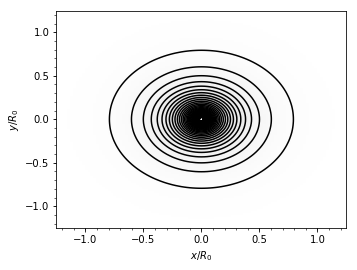

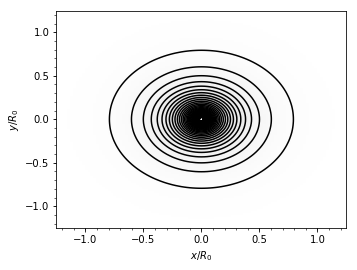

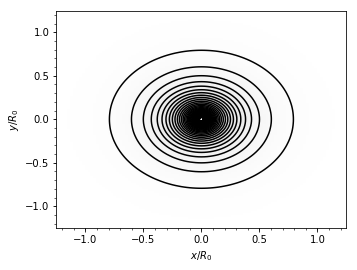

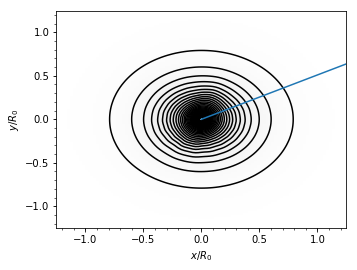

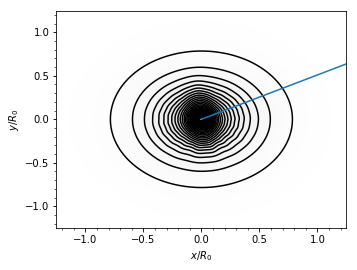

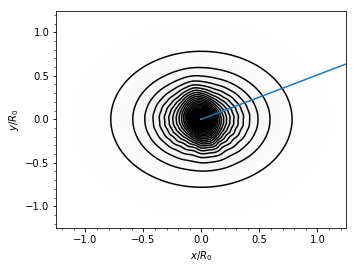

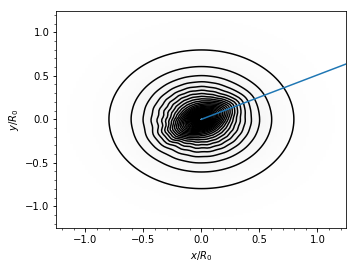

In [7]:
#plot the full MW density contours

# the bar is set 5 Gyrs in the past, positive time takes it forward in time, the bar is 2 Gyr old, so starting at 5 Gyr
# it starts turning on at 3 Gyr

#5 Gyr in the past
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=0.*u.Gyr,ncontours=80,xy=True)

#3 Gyr in the past
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=2.0*u.Gyr,ncontours=80,xy=True)

#2 Gyr in the past
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=3.*u.Gyr,ncontours=80,xy=True)


plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=3.02*u.Gyr,ncontours=80,xy=True)
plot([0.,10.],[0,10.*np.tan(np.radians(27))])

plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=3.03*u.Gyr,ncontours=80,xy=True)
plot([0.,10.],[0,10.*np.tan(np.radians(27))])

plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=3.8*u.Gyr,ncontours=80,xy=True)
plot([0.,10.],[0,10.*np.tan(np.radians(27))])

#present day
plotDensities(barpot,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=5.*u.Gyr,ncontours=80,xy=True)
plot([0.,10.],[0,10.*np.tan(np.radians(27))])




# Plot density contour evolution in the inverted barred MW potential to see how the bar de-evolves, the straight line is at 27 deg to check whether the bar aligns with that today. The view is from the South Galactic Cap.

/home/nil/anaconda3/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/nil/anaconda3/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/SCFPotential.py:201: RuntimeWarning: divide by zero encountered in true_divide
  rho[:,:] = K * ((a*r)**l) / ((r/a)*(a + r)**(2*l + 3.)) * CC[:,:]* (nu.pi)**-0.5

/home/nil/anaconda3/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/SCFPotential.py:201: RuntimeWarning: invalid value encountered in true_divide
  rho[:,:] = K * ((a*r)**l) / ((r/a)*(a + r)**(2*l + 3.)) * CC[:,:]* (nu.pi)**-0.5

/home/nil/anaconda3/lib/python3.6/site-packages/galpy-1.4.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/SCFPotential.py:258: RuntimeWarning: invalid value encountered in

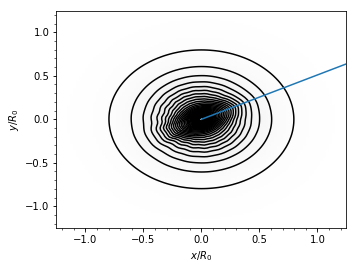

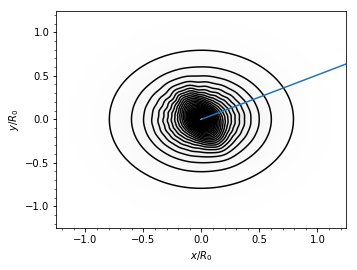

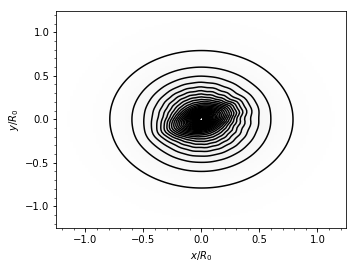

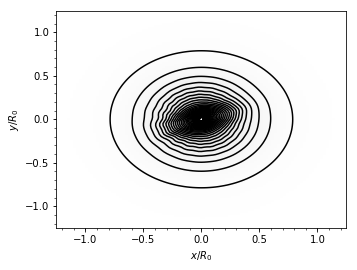

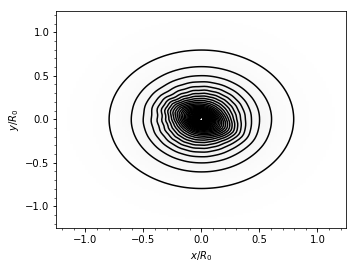

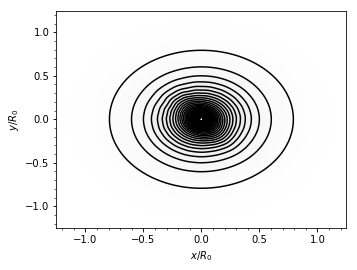

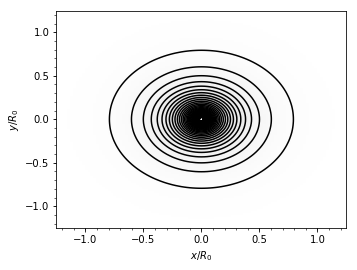

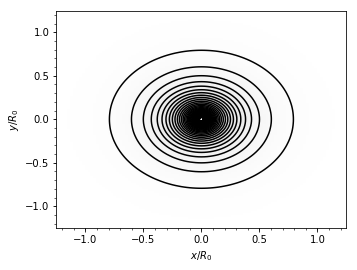

In [8]:
#today
plotDensities(barpot_invert,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=0.*u.Gyr,ncontours=80,xy=True)
plot([0.,10.],[0,10.*np.tan(np.radians(27))])

#0.5 Gyr in the past
plotDensities(barpot_invert,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=0.5*u.Gyr,ncontours=80,xy=True)
plot([0.,10.],[0,10.*np.tan(np.radians(27))])

#1 Gyr in the past
plotDensities(barpot_invert,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=1.0*u.Gyr,ncontours=80,xy=True)

plotDensities(barpot_invert,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=2.*u.Gyr,ncontours=80,xy=True)

plotDensities(barpot_invert,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=2.02*u.Gyr,ncontours=80,xy=True)

plotDensities(barpot_invert,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=2.03*u.Gyr,ncontours=80,xy=True)

plotDensities(barpot_invert,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=3.*u.Gyr,ncontours=80,xy=True)

plotDensities(barpot_invert,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmax=10.*u.kpc,zmin=-10.*u.kpc,phi=0.,nrs=101,nzs=101,t=5.*u.Gyr,ncontours=80,xy=True)


# plot the orbits of Pal 5 progenitor with and without bar

[1.0264875226538015, -0.2156334802264303, 0.49344889498306443, 2.077779514547263, -0.07124373088418981, 3.112933680628011]
[ 1.02644722 -0.21561376  0.49346827  2.0777626  -0.07129471  3.11301969]
[ 1.03471451 -0.2204616   0.48866512  2.08186868 -0.05727591  3.09079493]


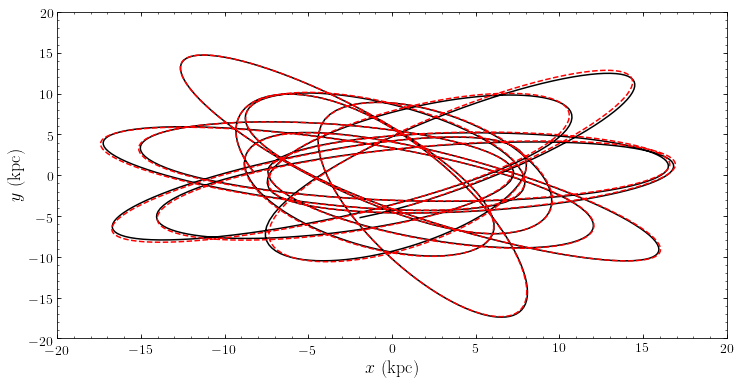

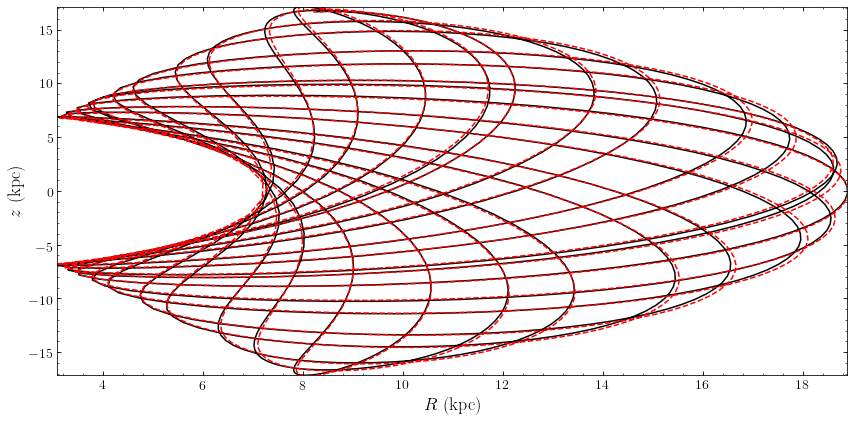

In [9]:
tpal5=numpy.linspace(0.,5.,1001)*u.Gyr#/bovy_conversion.time_in_Gyr(220.,8.)

pal5= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25])
print (pal5._orb.vxvv)


#integrate Pal 5 back and then forward for 5 Gyr in nobarpot to see how well we end up where we started
pal5_nobar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25]).flip() 
pal5_nobar.integrate(tpal5,nobarpot)

pal5_nobar_init=pal5_nobar(tpal5[-1]).flip()._orb.vxvv
p5nobar=Orbit(pal5_nobar_init,ro=ro,vo=vo)
p5nobar.integrate(tpal5,nobarpot)
print (p5nobar(tpal5[-1])._orb.vxvv)



#integrate Pal 5 back in barpot_invert and then forward for 5 Gyr in the barpot to see how well we end up where we started
pal5_bar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25]).flip() 
pal5_bar.integrate(tpal5,barpot_invert)

pal5_bar_init=pal5_bar(tpal5[-1]).flip()._orb.vxvv
p5bar=Orbit(pal5_bar_init,ro=ro,vo=vo)
p5bar.integrate(tpal5,barpot)
print (p5bar(tpal5[-1])._orb.vxvv)

#plot their orbits
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,6)

p5bar.plot(d1='x',d2='y',xrange=[-20.,20.],yrange=[-20.,20.],c='k')
p5nobar.plot(d1='x',d2='y',xrange=[-20.,20.],yrange=[-20.,20.],c='r',ls='--',overplot=True)



p5bar.plot(c='k')
p5nobar.plot(c='r',ls='--',overplot=True)

tight_layout()


In [10]:
#coloring stuff

cmap= cm.plasma

def color_from_colormap(val,cmap,cmin,cmax):
    va=[]
    for v in val:
        va.append(cmap((v-cmin)/(cmax-cmin)))
        
    return va

def add_discrete_colorbar_dens(vmin,vmax,clabel,ticks,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
    dtick= (ticks[1]-ticks[0])
    sm = pyplot.cm.ScalarMappable(cmap=tcmap,norm=pyplot.Normalize(vmin=vmin-0.5*dtick,vmax=vmax+0.5*dtick))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$',ticks=ticks)
    cbar.set_label(clabel)
    return None

def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

In [11]:
#setup Pal 5 smooth stream, only the trailing arm at the moment, for different potentials


sdf_trailing= pal5_util.setup_pal5model(pot=nobarpot)
#sdf_leading= pal5_util.setup_pal5model(pot=nobarpot,leading=True)

#Sample N points from the smooth model today 
N=200
Rt,vRt,vTt,zt,vzt,phit,dtt= sdf_trailing.sample(n=N,returndt=True)
#Rl,vRl,vTl,zl,vzl,phil,dtl= sdf_leading.sample(n=N,returndt=True)
#l,b,d,vlos,pmll,pmbb = sdf_smooth.sample(n=N,lb=True)

#trackRADec_trailing=bovy_coords.lb_to_radec(sdf_trailing._interpolatedObsTrackLB[:,0],
#                          sdf_trailing._interpolatedObsTrackLB[:,1],
#                          degree=True)

#trackRADec_leading=bovy_coords.lb_to_radec(sdf_leading._interpolatedObsTrackLB[:,0],
#                          sdf_leading._interpolatedObsTrackLB[:,1],
#                          degree=True)

#add color label based on time of stripping

#stripping time bins:
t_age= 5. 
dt_bins=np.linspace(0.,t_age,6)
print (dt_bins)

lt_unp=numpy.empty(N)
bt_unp=numpy.empty(N)
dtt_s=numpy.empty(N)

ll_unp=numpy.empty(N)
bl_unp=numpy.empty(N)
dtl_s=numpy.empty(N)

for i in range(N):
    dtt_s[i]=numpy.digitize(dtt[i]*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
    lt_unp[i]=galcencyl_to_lbd(Rt[i],phit[i],zt[i])[0]
    bt_unp[i]=galcencyl_to_lbd(Rt[i],phit[i],zt[i])[1]
    
    #dtl_s[i]=numpy.digitize(dtl[i]*bovy_conversion.time_in_Gyr(220.,8.),dt_bins)
    #ll_unp[i]=galcencyl_to_lbd(Rl[i],phil[i],zl[i])[0]
    #bl_unp[i]=galcencyl_to_lbd(Rl[i],phil[i],zl[i])[1]
    
radec1t=bovy_coords.lb_to_radec(lt_unp,bt_unp,degree=True) 
#radec1l=bovy_coords.lb_to_radec(ll_unp,bl_unp,degree=True)

[0. 1. 2. 3. 4. 5.]


In [12]:
# integrate these N particles *backward* in time to when they were all stripped (they were stripped dt in the past, dt is different for each particle); something like

finalRt= numpy.empty(N)
finalphit= numpy.empty(N)
finalzt= numpy.empty(N)

finalRt1= numpy.empty(N)
finalphit1= numpy.empty(N)
finalzt1= numpy.empty(N)


lt_p=numpy.empty(N)
bt_p=numpy.empty(N)

lt_p1=numpy.empty(N)
bt_p1=numpy.empty(N)


tpal5= numpy.linspace(0.,5.,1001)/bovy_conversion.time_in_Gyr(220.,8.)

for ii in range(N):
    ot= Orbit([Rt[ii],vRt[ii],vTt[ii],zt[ii],vzt[ii],phit[ii]]).flip() # flip flips the velocities for backwards integration
    tst= numpy.linspace(0.,dtt[ii],1001)
    ot.integrate(tst,nobarpot)
    unp_orb_t=ot(tst[-1]).flip()._orb.vxvv
    
    
    #dtt is time in the past from today, change that to time in the future starting from t_Pal5 dynamic age
    dtt_back=5./bovy_conversion.time_in_Gyr(220.,8.) - dtt[ii]
    
    tst_back= numpy.linspace(0.,dtt_back,1001)
    
    #integrate back and then forward in nobarpot    
    pal5_nobar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip() 
    pal5_nobar.integrate(tpal5,nobarpot)
    
    #flip again to get correct velocity of the progenitor
    pal5_orb_nobar_init=pal5_nobar(tpal5[-1]).flip()._orb.vxvv
    
    P5_nobar=Orbit(pal5_orb_nobar_init)
    P5_nobar.integrate(tst_back,nobarpot)
    P5_nobar_orb=P5_nobar(tst_back[-1])._orb.vxvv
    
    #integrate back and then forward in nobarpot 
    pal5_bar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip() 
    pal5_bar.integrate(tpal5,barpot_invert)
    
    #flip again to get correct velocity of the progenitor
    pal5_orb_bar_init=pal5_bar(tpal5[-1]).flip()._orb.vxvv
    
    P5_bar=Orbit(pal5_orb_bar_init)
    P5_bar.integrate(tst_back,barpot)
    P5_bar_orb=P5_bar(tst_back[-1])._orb.vxvv
    
    #subtract Pal 5 orb in nobarpot and add Pal 5 orbit in barpot
    pert_orb_t=(np.array(unp_orb_t) - np.array(P5_nobar_orb)) + np.array(P5_bar_orb)
    
   
    #print (unp_orb)
    #print (list(pert_orb))
    #print (P5_nobar_orb)
    #print (P5_bar_orb)
    
    pert_orb_t=Orbit(list(pert_orb_t))
    
    
    
    pert_orb_t.integrate(tst,barpot)
    finalRt[ii]= pert_orb_t.R(tst[-1])
    finalphit[ii]= pert_orb_t.phi(tst[-1])
    finalzt[ii]= pert_orb_t.z(tst[-1])
    
    
    orbs_t=ot(tst[-1]).flip()
    
    orbs_t.integrate(tst,barpot)
    
    finalRt1[ii]= orbs_t.R(tst[-1])
    finalphit1[ii]= orbs_t.phi(tst[-1])
    finalzt1[ii]= orbs_t.z(tst[-1])
    
    #convert to (l,b)   
    lt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[0]
    bt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[1]
    
    lt_p1[ii]=galcencyl_to_lbd(finalRt1[ii],finalphit1[ii],finalzt1[ii])[0]
    bt_p1[ii]=galcencyl_to_lbd(finalRt1[ii],finalphit1[ii],finalzt1[ii])[1]

radecpt=bovy_coords.lb_to_radec(lt_p,bt_p,degree=True)  
radecpt1=bovy_coords.lb_to_radec(lt_p1,bt_p1,degree=True)  

/home/nil/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "



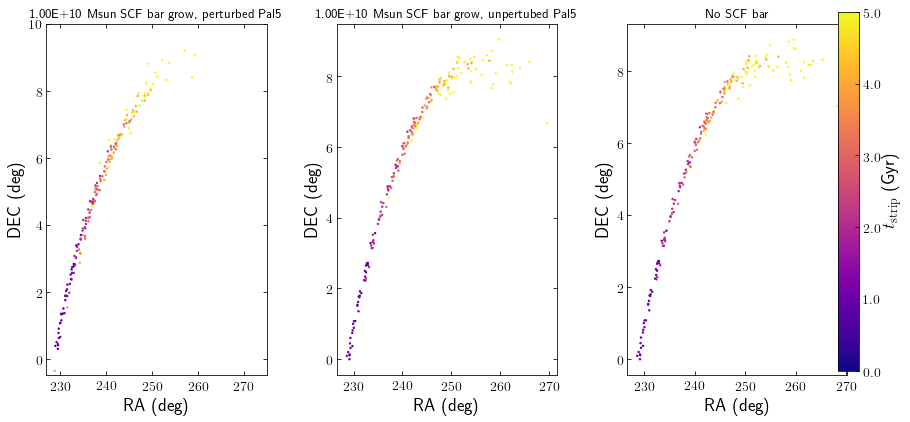

In [13]:
from decimal import Decimal

plt.figure(figsize=(12,6))
plt.subplot(1,3, 1)
plt.title('%.2E Msun SCF bar grow, perturbed Pal5'%Decimal(Mbar))

plt.scatter(radecpt[:,0],radecpt[:,1],s=2,color=color_from_colormap(dtt_s,cmap,0.,5.))
#plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k',label='unperturbed')

#plt.scatter(radecpl[:,0],radecpl[:,1],s=2,color=color_from_colormap(dtl_s,cmap,0.,5.))
#plt.plot(trackRADec_leading[:,0],trackRADec_leading[:,1],lw=2,c='k')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.xlim(227,275)
plt.ylim(-0.5,10.)

plt.subplot(1,3, 2)
plt.title('%.2E Msun SCF bar grow, unpertubed Pal5'%Decimal(Mbar))

plt.scatter(radecpt1[:,0],radecpt1[:,1],s=2,color=color_from_colormap(dtt_s,cmap,0.,5.))
#plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k',label='unperturbed')

#plt.scatter(radecpl[:,0],radecpl[:,1],s=2,color=color_from_colormap(dtl_s,cmap,0.,5.))
#plt.plot(trackRADec_leading[:,0],trackRADec_leading[:,1],lw=2,c='k')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')



plt.subplot(1, 3, 3)
plt.title('No SCF bar')

plt.scatter(radec1t[:,0],radec1t[:,1],s=2,color=color_from_colormap(dtt_s,cmap,0.,5.))
#plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='k',label='unperturbed')


#plt.scatter(radec1l[:,0],radec1l[:,1],s=2,color=color_from_colormap(dtl_s,cmap,0.,5.))
#plt.plot(trackRADec_leading[:,0],trackRADec_leading[:,1],lw=2,c='k')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
#plt.legend(loc='upper left')
add_colorbar(0.,5.,r'$t_{\rm{strip}}$ (Gyr)')
tight_layout()
#plt.savefig('plots/Pal5_Mbar10_10Msun_patspeed65_barangle27.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()

#plt.figure()
#plt.scatter(radecpt[:,0],radecpt[:,1],s=2,color=color_from_colormap(dtt_s,cmap,0.,5.))
#plt.xlabel('RA (deg)')
#plt.ylabel('DEC (deg)')

plt.show()

In [ ]:
finalRl= numpy.empty(N)
finalphil= numpy.empty(N)
finalzl= numpy.empty(N)

finalRl1= numpy.empty(N)
finalphil1= numpy.empty(N)
finalzl1= numpy.empty(N)

ll_p=numpy.empty(N)
bl_p=numpy.empty(N)

ll_p1=numpy.empty(N)
bl_p1=numpy.empty(N)


for ii in range(N):   
    #For leading arm
    ol= Orbit([Rl[ii],vRl[ii],vTl[ii],zl[ii],vzl[ii],phil[ii]]).flip() # flip flips the velocities for backwards integration
    tsl= numpy.linspace(0.,dtl[ii],1001)
    ol.integrate(tsl,nobarpot)
    unp_orb_l=ol(tsl[-1]).flip()._orb.vxvv
    
    
    #dtt is time in the past from today, change that to time in the future starting from t_Pal5 dynamic age
    dtl_back=5./bovy_conversion.time_in_Gyr(220.,8.) - dtl[ii]
    
    tsl_back= numpy.linspace(0.,dtl_back,1001)
    
    #integrate back and then forward in nobarpot    
    pal5_nobar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip() 
    pal5_nobar.integrate(tpal5,nobarpot)
    
    #flip again to get correct velocity of the progenitor
    pal5_orb_nobar_init=pal5_nobar(tpal5[-1]).flip()._orb.vxvv
    
    P5_nobar=Orbit(pal5_orb_nobar_init)
    P5_nobar.integrate(tst_back,nobarpot)
    P5_nobar_orb=P5_nobar(tst_back[-1])._orb.vxvv
    
    #integrate back and then forward in nobarpot 
    pal5_bar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip() 
    pal5_bar.integrate(tpal5,barpot_invert)
    
    #flip again to get correct velocity of the progenitor
    pal5_orb_bar_init=pal5_bar(tpal5[-1]).flip()._orb.vxvv
    
    P5_bar=Orbit(pal5_orb_bar_init)
    P5_bar.integrate(tst_back,barpot)
    P5_bar_orb=P5_bar(tst_back[-1])._orb.vxvv
    
    #subtract Pal 5 orb in nobarpot and add Pal 5 orbit in barpot
    pert_orb_l=(np.array(unp_orb_l) - np.array(P5_nobar_orb)) + np.array(P5_bar_orb)
    
   
    #print (unp_orb)
    #print (list(pert_orb))
    #print (P5_nobar_orb)
    #print (P5_bar_orb)
    
    pert_orb_l=Orbit(list(pert_orb_l))
    
    
    
    pert_orb_l.integrate(tsl,barpot)
    finalRl[ii]= pert_orb_l.R(tsl[-1])
    finalphil[ii]= pert_orb_l.phi(tsl[-1])
    finalzl[ii]= pert_orb_l.z(tsl[-1])
    
    
    orbs_l=ol(tsl[-1]).flip()
    
    orbs_l.integrate(tsl,barpot)
    
    finalRl1[ii]= orbs_l.R(tsl[-1])
    finalphil1[ii]= orbs_l.phi(tsl[-1])
    finalzl1[ii]= orbs_l.z(tsl[-1])
    
    #convert to (l,b)   
    ll_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[0]
    bl_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[1]
    
    ll_p1[ii]=galcencyl_to_lbd(finalRl1[ii],finalphil1[ii],finalzl1[ii])[0]
    bl_p1[ii]=galcencyl_to_lbd(finalRl1[ii],finalphil1[ii],finalzl1[ii])[1]
    
       
    
radecpl=bovy_coords.lb_to_radec(ll_p,bl_p,degree=True)  
radecpl1=bovy_coords.lb_to_radec(ll_p1,bl_p1,degree=True)  
    


In [ ]:
orbs=orbitst

t_bar_on_Gyr= 1.5 #Gyr in the past 
t_on=t_bar_on_Gyr/bovy_conversion.time_in_Gyr(vo,ro)


for ii in range(N):    
#forward integrate in barred potential
    tst= numpy.linspace(0.,dtt[ii],1001)
    
    orbs[ii].integrate(tst,barpot)
    
    finalRt1[ii]= orbs[ii].R(tst[-1])
    finalphit1[ii]= orbs[ii].phi(tst[-1])
    finalzt1[ii]= orbs[ii].z(tst[-1])
    
    if dtt[ii] > t_on :
        
        tbefore= tst[tst < (dtt[ii]-t_on)]
        #print (tbefore)
        orbitst[ii].integrate(tbefore,nobarpot)
        
        #initialize new orbit 
        neworbitst= orbitst[ii](tbefore[-1])
        
        nt=len(tst[tst >=(dtt[ii]-t_on)])
        tafter=numpy.linspace(0.,t_on,nt)
        #print (tafter)
        neworbitst.integrate(tafter,barpot) 
        
        finalRt[ii]= neworbitst.R(tafter[-1])
        finalphit[ii]= neworbitst.phi(tafter[-1])
        finalzt[ii]= neworbitst.z(tafter[-1])
        
         
    else :
        orbitst[ii].integrate(tst,barpot)
        finalRt[ii]= orbitst[ii].R(tst[-1])
        finalphit[ii]= orbitst[ii].phi(tst[-1])
        finalzt[ii]= orbitst[ii].z(tst[-1])
    '''    
    tsl= numpy.linspace(0.,dtl[ii],1001)
    
    if dtl[ii] > t_on :
        tbefore= tsl[tsl < (dtl[ii]-t_on)]
        orbitsl[ii].integrate(tbefore,nobarpot)
        
        #initialize new orbit 
        neworbitsl= orbitsl[ii](tbefore[-1])
        
        nl=len(tsl[tsl >=(dtl[ii]-t_on)])
        tafter=numpy.linspace(0.,t_on,nl)
        neworbitsl.integrate(tafter,barpot) 
        
        finalRl[ii]= neworbitsl.R(tafter[-1])
        finalphil[ii]= neworbitsl.phi(tafter[-1])
        finalzl[ii]= neworbitsl.z(tafter[-1])
        
         
    else :
        orbitsl[ii].integrate(tsl,barpot)
        finalRl[ii]= orbitsl[ii].R(tsl[-1])
        finalphil[ii]= orbitsl[ii].phi(tsl[-1])
        finalzl[ii]= orbitsl[ii].z(tsl[-1])
        
    '''   
    #convert to (l,b)
    lt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[0]
    bt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[1]
    
    lt_p1[ii]=galcencyl_to_lbd(finalRt1[ii],finalphit1[ii],finalzt1[ii])[0]
    bt_p1[ii]=galcencyl_to_lbd(finalRt1[ii],finalphit1[ii],finalzt1[ii])[1]
    
    #ll_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[0]
    #bl_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[1]
    
    
radecpt=bovy_coords.lb_to_radec(lt_p,bt_p,degree=True)  
radecpt1=bovy_coords.lb_to_radec(lt_p1,bt_p1,degree=True)  
#radecpl=bovy_coords.lb_to_radec(ll_p,bl_p,degree=True) 
     
        

In [ ]:
t_bar_on_Gyr= 1. #Gyr in the past 
t_on=t_bar_on_Gyr/bovy_conversion.time_in_Gyr(vo,ro)

dtt=2./bovy_conversion.time_in_Gyr(vo,ro)

ts= numpy.linspace(0.,dtt,1001)

orb=[1.,0.1,0.03,0.,0.1,0.] 
orb_nobar=orb.integrate(ts,nobarpot)

tbefore= ts[ts < (dtt[ii]-t_on)]
tafter=tst[tst >=(dtt[ii]-t_on)]
orb_bar=orb.integrate(ts,nobarpot)
    

Mbar=10**10.

ts= numpy.linspace(0,1.,1001)*u.Gyr
def plot_orbit_comparison(o):
    o.integrate(ts,MWPotentialSCFbar(Mbar,pat_speed=35.,fin_phi=27.)[0])
    o.plot(yrange=[-2.,2.],xrange=[0.,9.],gcf=True,c='r')
    o.integrate(ts,MWPotentialSCFbar(Mbar,pat_speed=35.,fin_phi=27.)[1])
    o.plot(overplot=True,gcf=True)
    return None

def plot_orbit_comparisonXY(o):
    o.integrate(ts,MWPotentialSCFbar(Mbar,pat_speed=35.,fin_phi=27.)[0])
    o.plot(d1='x',d2='y',xrange=[-10.,10.],yrange=[-10.,10.],gcf=True,c='r')
    o.integrate(ts,MWPotentialSCFbar(Mbar,pat_speed=35.,fin_phi=27.)[1])
    o.plot(d1='x',d2='y',overplot=True,gcf=True)
    return None


#vxvv=[R,vR,vT,z,vz,phi]

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,6)
subplot(2,2,1)
o= Orbit([1.,0.1,0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,2)
o= Orbit([1.,0.1,-0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,3)
o= Orbit([1.,0.05,0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,4)
o= Orbit([1.,0.05,-0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
tight_layout()  

    
    

In [ ]:
for ii in range(N):    
#forward integrate in barred potential
    tst= numpy.linspace(0.,dtt[ii],1001)
    t_before = tst[]
    orbitst[ii].integrate(tst,barpot)
    finalRt[ii]= orbitst[ii].R(tst[-1])
    finalphit[ii]= orbitst[ii].phi(tst[-1])
    finalzt[ii]= orbitst[ii].z(tst[-1])
       
    #leading
    orbitsl[ii].integrate(tsl,barpot)
    finalRl[ii]= orbitsl[ii].R(tsl[-1])
    finalphil[ii]= orbitsl[ii].phi(tsl[-1])
    finalzl[ii]= orbitsl[ii].z(tsl[-1])
    
    
    #convert to (l,b)
    lt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[0]
    bt_p[ii]=galcencyl_to_lbd(finalRt[ii],finalphit[ii],finalzt[ii])[1]
    
    ll_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[0]
    bl_p[ii]=galcencyl_to_lbd(finalRl[ii],finalphil[ii],finalzl[ii])[1]
    
    
radecpt=bovy_coords.lb_to_radec(lt_p,bt_p,degree=True)   
radecpl=bovy_coords.lb_to_radec(ll_p,bl_p,degree=True) 

In [ ]:
#check pattern 
pat_speed=40.


kpc_to_km= 1000*bovy_conversion._PCIN10p18CM*(10**18.)/(10**5.)
Gyr_to_s = 1000.*bovy_conversion._MyrIn1013Sec*10**13.
o_p = (2.*np.pi)*(pat_speed/kpc_to_km)  #rad/s

print (2.*np.pi/o_p/Gyr_to_s)

print (2.*np.pi/o_p/Gyr_to_s/bovy_conversion.time_in_Gyr(vo,ro))

tform=2.

tform=-tform/bovy_conversion.time_in_Gyr(vo,ro)

print (tform)
